### 1. Import necessary libraries

In [1]:
import os
import time
import math
import warnings
import random
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import pickle
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import models
from torch.utils.data import DataLoader, sampler, random_split, TensorDataset

# turn off warnings
warnings.filterwarnings("ignore")
# set environment to solve the conflict between pytorch and matplotlib
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### 2. Configure PyTorch environment

In [2]:
# define a function that returns a consistent, predetermined random number
def fix_random_seed(seed_no = 0):
    torch.manual_seed(seed_no)
    torch.cuda.manual_seed(seed_no)
    random.seed(seed_no)

In [3]:
# define the configuration of torch
dtype = torch.float
gpu_index = torch.randint(0, torch.cuda.device_count(), (1,)).item()
device = torch.device('cuda:{}'.format(gpu_index))
print("PyTorch is using GPU {}!".format(device))

PyTorch is using GPU cuda:0!


### 3. Bin price target into 8 categories for classification task

In [4]:
# read the guitar info
df = pd.read_csv("guitar_info.csv")

# load the valid guitar image indice
train_data_id = []
file_path = "guitar_resized_images"

# walk through all resized guitar images
for root, dirs, files in os.walk(file_path):
    for file in files:
        train_data_id.append(int(file.replace(".png","")))
        
# select the guitar info of resized images
df = df[df['index'].isin(train_data_id)]
df['price'] = df['price'].apply(lambda x:math.ceil(float(x.replace("$","").replace(",",""))))

# remove 36 outliers that have exorbitant price 
df = df[df['price']<5000]

# split the price into 8 different ranges
num_bins = 8
bins = [0, 200, 400, 600, 800, 1100, 1500, 2200, 5000]
labels = [f'Price_Bin_{i+1}' for i in range(num_bins)]

# perform the quantile binning
df['price_bin'] = pd.cut(df['price'], bins = bins, labels=labels, right=True, include_lowest=True)

# concatenate the price bins
df = pd.concat([df,pd.get_dummies(df['price_bin'])],axis=1)

# display the price interval
for label, lower_bound, upper_bound in zip(labels, bins[:-1], bins[1:]):
    print(f"{label}: ({lower_bound:.0f}, {upper_bound:.0f}]")
    
# add the path of images to dataframe
df['path'] = df['index'].apply(lambda x:'guitar_resized_images/000000'+ str(x) + '.png')

Price_Bin_1: (0, 200]
Price_Bin_2: (200, 400]
Price_Bin_3: (400, 600]
Price_Bin_4: (600, 800]
Price_Bin_5: (800, 1100]
Price_Bin_6: (1100, 1500]
Price_Bin_7: (1500, 2200]
Price_Bin_8: (2200, 5000]


### 4. Process numerical and categorical features

In [5]:
# include additional guitar information: brand, condition and selling location
# extract the brand of guitar from the title
df['brand'] = df['title'].apply(lambda x: " ".join(x.split(" ")[1:]))
df['brand'] = df['brand'].apply(lambda x: x.replace("Used ","").split(" ")[0])
df_brand = df['brand'].value_counts().reset_index()
main_brand = list(df_brand[df_brand['brand']>5]['index'])
df['brand'] = df['brand'].apply(lambda x: x if x in main_brand else 'Other')

# extract the state from the 'location' column
df['location'] = df['location'].apply(lambda x: x.split(",")[1])

# convert guitar condition categories to ordinal numbers reflecting their quality
condition_mapping = {'Poor': 0,'Fair': 1,'Good': 2,'Great': 3,'Excellent': 4}
df['condition'] = df['condition'].map(condition_mapping)

# concatenate all one-hot encoded features
df_brand = pd.get_dummies(df['brand'], prefix='brand')
feature1 = df_brand.columns
df_location = pd.get_dummies(df['location'], prefix='location')
feature2 = df_location.columns
df = pd.concat([df, df_brand,df_location], axis=1)

# determine the feature for tabular data
tabular_features = list(feature1).copy()
tabular_features.extend(list(feature2))
tabular_features.extend(["condition"])

### 5. Prepare datasets

In [6]:
# define a class to generate training, validation, and testing set
class Guitar_Tabular_Data_Set:
    """ this class is designed to generate training, validation, and testing set from guitar images"""
    def __init__(self, dataframe):
        self.df = dataframe
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        # retrieve the image based on the file path
        path_idx = self.df['path'].iloc[idx]

        # convert the tabular data to torch.tensor
        tabular = torch.tensor(self.df[tabular_features].iloc[idx], device=device, dtype=dtype)

        # convert price from dataframe to torch.tensor
        price = torch.tensor(self.df[labels].iloc[idx], device=device, dtype=dtype)
        price = price.to(device=device, dtype=dtype)

        return tabular, price

# define a function to extract small number of batches.
def subset_of_dataloader(dataloader, num_batches):
    subset_data = []
    for i, data in enumerate(dataloader):
        subset_data.append(data)
        if i + 1 == num_batches:
            break
    return subset_data

In [7]:
# create training, validation, and testing data set
fix_random_seed()

# create an instance of the Dataset
guitar_tabular_dataset = Guitar_Tabular_Data_Set(dataframe = df)

# define the ratio for training, validation, and testing set
total = len(guitar_tabular_dataset)
train = 0.7
validation = 0.15

# split the whole dataset into training, validation, and testing set
train_size = int(train * total)
validation_size = int(validation * total)
test_size = total - train_size - validation_size
train_dataset, validation_dataset, test_dataset = random_split(guitar_tabular_dataset, [train_size, validation_size, test_size])

loader_train = DataLoader(train_dataset, batch_size=32,shuffle = True)
loader_val = DataLoader(validation_dataset, batch_size=32,shuffle = True)
loader_test = DataLoader(test_dataset, batch_size=32,shuffle = True)

# extract small number of batches from training set to determine the model architecture, learning rate, etc
loader_small = subset_of_dataloader(loader_train, 10)

### 6. Train model using Neural Network Architecture

In [8]:
# define a function for adjusting learning rate
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
    """
    Multiply lrd to the learning rate if epoch is in schedule

    Inputs:
    - optimizer: An Optimizer object we will use to train the model
    - lrd: learning rate decay; a factor multiplied at scheduled epochs
    - epochs: the current epoch number
    - schedule: the list of epochs that requires learning rate update

    Returns: Nothing, but learning rate might be updated
    """
    if epoch in schedule:
        for param_group in optimizer.param_groups:
            print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
            param_group['lr'] *= lrd


# define a function to initialize the weight
def initialize_weight(m, init_type):
    if isinstance(m, nn.Linear):
        if init_type == 'kaiming':
            init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        elif init_type == 'xavier':
            init.xavier_uniform_(m.weight)
        elif init_type == 'uniform':
            init.uniform_(m.weight, a=-0.1, b=0.1)
        if m.bias is not None:
            init.zeros_(m.bias)          
            

# define a function for training the model
def train_model(model, optimizer, dataset, epochs=1, learning_rate_decay=.1, schedule=[], criterion = nn.CrossEntropyLoss(), print_every = 100, validate = True):
    """
    Train a model on guitar image dataset using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
     # define a list to record the model performance in each iteration
    train_acc = []
    val_acc = []
    result = []
    num_iters = epochs * len(dataset)
    num_prints = num_iters // print_every + 1

    for e in range(epochs):
        
        adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

        for t, (x, y) in enumerate(dataset):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            outputs = model(x)
            
            # calculatet the loss using assigned criterion 
            loss = criterion(outputs, y)
            
            # zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()

            # this is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            result.append((e+1,t+1,loss.item()))
            
            if validate and t % print_every == 0:
                _, accuracy, _, _, _ = evaluate_model(model, dataset, 10)
                val_loss, val_accuracy, _, _, _ = evaluate_model(model, loader_val, 10)
                train_acc.append((e + 1, accuracy))
                val_acc.append((e + 1, val_accuracy))
                print('Epoch %d, Iteration %d, loss = %.4f, val_loss = %.4f, accuracy = %.4f, val_accuracy = %.4f' % (e, t, loss.item(), val_loss, accuracy, val_accuracy))
            elif not validate and t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))

    return train_acc, val_acc, result


# define a function to evaluate the model performance
def evaluate_model(model, dataset, num_classes):
    model.to(device).eval()  # Move model to device and set to evaluation mode
    criterion = torch.nn.CrossEntropyLoss()  # Assuming you're using CrossEntropyLoss

    accuracy = torchmetrics.Accuracy(average='weighted', num_classes=num_classes, task='multiclass').to(device)
    precision = torchmetrics.Precision(average='weighted', num_classes=num_classes, task='multiclass').to(device)
    recall = torchmetrics.Recall(average='weighted', num_classes=num_classes, task='multiclass').to(device)
    f1 = torchmetrics.F1Score(average='weighted', num_classes=num_classes, task='multiclass').to(device)

    total_loss = 0
    total_count = 0

    with torch.no_grad():
        for tabulars, labels in dataset:
            labels = torch.argmax(labels, dim=1) 
            tabulars, labels = tabulars.to(device=device), labels.to(device=device)

            outputs = model(tabulars)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_count += labels.size(0)

            _, predicted = torch.max(outputs, 1)
            accuracy.update(predicted, labels)
            precision.update(predicted, labels)
            recall.update(predicted, labels)
            f1.update(predicted, labels)

    # Compute final metrics
    final_loss = total_loss / total_count
    final_accuracy = accuracy.compute()
    final_precision = precision.compute()
    final_recall = recall.compute()
    final_f1 = f1.compute()
    
    return final_loss, final_accuracy.item(), final_precision.item(), final_recall.item(), final_f1.item()


# define a function to visualize the accuracy in the training process
def plot_accuracy(train,val):
    df_train = pd.DataFrame(train,columns = ['epoch','accuracy'])
    df_val = pd.DataFrame(val,columns = ['epoch','accuracy'])
    sns.lineplot(data = df_train, x = 'epoch', y = 'accuracy',c ='blue',linewidth = 4 ,label = 'train')
    sns.lineplot(data = df_val, x = 'epoch', y = 'accuracy',c ='red',linewidth = 4 ,label = 'validation')
    plt.show()


# define a function to visualize the training loss
def plot_loss(result):
    df_train = pd.DataFrame(result,columns = ['epoch','iteration','loss'])
    df_avg = df_train.groupby('epoch').mean()['loss'].reset_index()
    sns.scatterplot(data = df_train, x = 'epoch', y = 'loss')
    sns.lineplot(data = df_avg, x = 'epoch', y = 'loss',c = '#3EBCBE', linewidth = 4)
    plt.show()    

Epoch 0, Iteration 0, loss = 2.1889, val_loss = 2.0244, accuracy = 0.2439, val_accuracy = 0.2550
Epoch 1, Iteration 0, loss = 1.8843, val_loss = 1.8531, accuracy = 0.2919, val_accuracy = 0.2927
Epoch 2, Iteration 0, loss = 1.8578, val_loss = 1.7125, accuracy = 0.3175, val_accuracy = 0.3060
Epoch 3, Iteration 0, loss = 1.7498, val_loss = 1.6587, accuracy = 0.3403, val_accuracy = 0.3415
Epoch 4, Iteration 0, loss = 2.0442, val_loss = 1.6695, accuracy = 0.3555, val_accuracy = 0.3370
Epoch 5, Iteration 0, loss = 1.4892, val_loss = 1.6447, accuracy = 0.3631, val_accuracy = 0.3370
Epoch 6, Iteration 0, loss = 1.6652, val_loss = 1.6214, accuracy = 0.3645, val_accuracy = 0.3592
Epoch 7, Iteration 0, loss = 1.3928, val_loss = 1.6109, accuracy = 0.3849, val_accuracy = 0.3370
Epoch 8, Iteration 0, loss = 1.6266, val_loss = 1.6275, accuracy = 0.3882, val_accuracy = 0.3326
Epoch 9, Iteration 0, loss = 1.6237, val_loss = 1.6214, accuracy = 0.3844, val_accuracy = 0.3282
Epoch 10, Iteration 0, loss = 

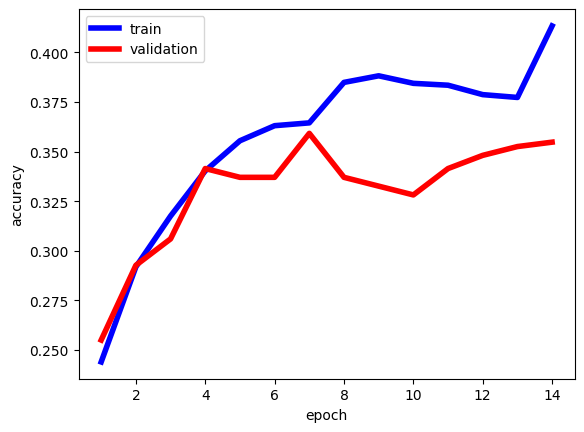

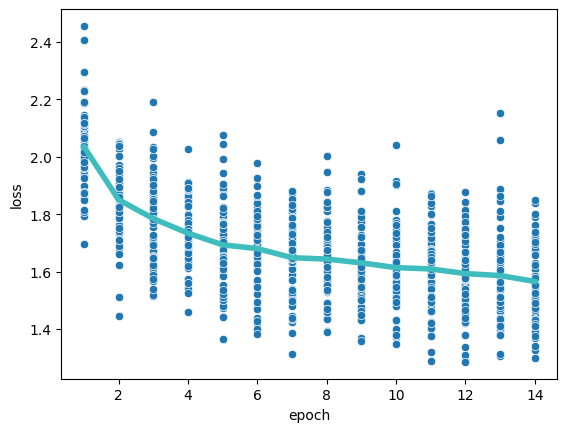

The Model Performance for DenseNet:
Testing - Loss: 1.6032, Accuracy: 0.3540, Precision: 0.3410, Recall: 0.3540, F1 Score: 0.3021


In [9]:
# create a fully connected neural network to fit tabular data
fix_random_seed(0)

tabular_model = nn.Sequential(
    nn.Linear(91, 512),  
    nn.ReLU(),           
    nn.Dropout(0.3),     
    nn.Linear(512, 256), 
    nn.ReLU(),           
    nn.Dropout(0.3),     
    nn.Linear(256, 128), 
    nn.ReLU(),           
    nn.Dropout(0.2),     
    nn.Linear(128, 8)   
)

# set up the hyperparameters
learning_rate = 1e-3
learning_rate_schedule = []
weight_decay = 1e-3
epochs = 14 # early stop to avoid overfitting

# use Kaiming initialization to initialize the weight
tabular_model.apply(lambda m: initialize_weight(m, init_type='kaiming'))
tabular_model.to(device)

# choose Adam as the optimizer
optimizer = optim.Adam(tabular_model.parameters(), 
                       lr=learning_rate, 
                       weight_decay = weight_decay
                      )

# train the model
train_acc,val_acc, result = train_model(model = tabular_model, 
                     optimizer = optimizer,
                     dataset = loader_train, 
                     learning_rate_decay = 0.1,
                     schedule = learning_rate_schedule,
                     epochs = epochs,
                     validate = True)

# plot the accuracy and loss
plot_accuracy(train_acc,val_acc)
plot_loss(result)

# evaluate the performance using testing set
loss, accuracy, precision, recall, f1 = evaluate_model(tabular_model, loader_test, num_classes = 10)
print("The Model Performance for DenseNet:")
print(f'Testing - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [10]:
# Save the tabular model
with open('tabular_model.pkl', 'wb') as f:
    pickle.dump(tabular_model, f)